# YOLOv2検討ノート

In [84]:
from __future__ import unicode_literals
from __future__ import print_function
import sys
import os
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import json

import chainer
import chainer.functions as F
import chainer.links as L

%reload_ext autoreload
%autoreload 2

%matplotlib inline
sns.set_style('whitegrid')

In [3]:
sys.version

'2.7.13 |Anaconda 4.3.0 (x86_64)| (default, Dec 20 2016, 23:05:08) \n[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]'

In [4]:
chainer.__version__

'1.22.0'

In [5]:
cv2.__version__

'3.1.0'

In [62]:
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('__file__')), '..', 'cmd', 'yolo', 'lib'))
from config import *
from yolo_v2 import *
from yolo_predictor import *
from bounding_box import *
from image_process import *

sys.path.append(os.path.join(os.path.dirname(os.path.abspath('__file__')), '..', 'cmd', 'yolo', 'detector'))
from yolo_trainer import *

## データセットの読み出し

In [8]:
with open(os.path.join('..', 'cache', 'SingleAug', 'single_aug_catalog.json'), 'r') as fp:
    catalog = json.load(fp)
    
train_dataset = filter(lambda item: item['bounding_boxes'] != [], catalog['dataset'])
len(train_dataset)

20000

In [9]:
INPUT_SIZE / 640., INPUT_SIZE / 480.

(0.35, 0.4666666666666667)

In [10]:
real_truth_boxes = np.asarray([[dict_to_box(box) for box in item['bounding_boxes']]
                                for item in train_dataset])
real_truth_boxes[0:10]

array([[<Box x:280.0 y:135.0 w:283.0 h:310.0 c:17 o:1.0>],
       [<Box x:19.0 y:0.0 w:592.0 h:416.0 c:11 o:1.0>],
       [<Box x:269.0 y:207.0 w:207.0 h:211.0 c:5 o:1.0>],
       [<Box x:404.0 y:87.0 w:97.0 h:353.0 c:15 o:1.0>],
       [<Box x:53.0 y:127.0 w:250.0 h:291.0 c:17 o:1.0>],
       [<Box x:270.0 y:115.0 w:191.0 h:314.0 c:12 o:1.0>],
       [<Box x:36.0 y:0.0 w:429.0 h:425.0 c:4 o:1.0>],
       [<Box x:9.0 y:0.0 w:452.0 h:429.0 c:4 o:1.0>],
       [<Box x:178.0 y:0.0 w:160.0 h:432.0 c:13 o:1.0>],
       [<Box x:102.0 y:171.0 w:512.0 h:259.0 c:7 o:1.0>]], dtype=object)

In [11]:
yolo_truth_boxes = [[real_to_yolo_coord(box, 640, 480) for box in boxes]
                    for boxes in real_truth_boxes]
yolo_truth_boxes[0:10]

[[<Box x:98.0 y:63.0 w:99.05 h:144.666666667 c:17 o:1.0>],
 [<Box x:6.65 y:0.0 w:207.2 h:194.133333333 c:11 o:1.0>],
 [<Box x:94.15 y:96.6 w:72.45 h:98.4666666667 c:5 o:1.0>],
 [<Box x:141.4 y:40.6 w:33.95 h:164.733333333 c:15 o:1.0>],
 [<Box x:18.55 y:59.2666666667 w:87.5 h:135.8 c:17 o:1.0>],
 [<Box x:94.5 y:53.6666666667 w:66.85 h:146.533333333 c:12 o:1.0>],
 [<Box x:12.6 y:0.0 w:150.15 h:198.333333333 c:4 o:1.0>],
 [<Box x:3.15 y:0.0 w:158.2 h:200.2 c:4 o:1.0>],
 [<Box x:62.3 y:0.0 w:56.0 h:201.6 c:13 o:1.0>],
 [<Box x:35.7 y:79.8 w:179.2 h:120.866666667 c:7 o:1.0>]]

In [12]:
ts = [[yolo_to_grid_coord(box) for box in boxes] for boxes in yolo_truth_boxes]
ts[0:10]

[[<Box x:3.0625 y:1.96875 w:3.0953125 h:4.52083333333 c:17 o:1.0>],
 [<Box x:0.2078125 y:0.0 w:6.475 h:6.06666666667 c:11 o:1.0>],
 [<Box x:2.9421875 y:3.01875 w:2.2640625 h:3.07708333333 c:5 o:1.0>],
 [<Box x:4.41875 y:1.26875 w:1.0609375 h:5.14791666667 c:15 o:1.0>],
 [<Box x:0.5796875 y:1.85208333333 w:2.734375 h:4.24375 c:17 o:1.0>],
 [<Box x:2.953125 y:1.67708333333 w:2.0890625 h:4.57916666667 c:12 o:1.0>],
 [<Box x:0.39375 y:0.0 w:4.6921875 h:6.19791666667 c:4 o:1.0>],
 [<Box x:0.0984375 y:0.0 w:4.94375 h:6.25625 c:4 o:1.0>],
 [<Box x:1.946875 y:0.0 w:1.75 h:6.3 c:13 o:1.0>],
 [<Box x:1.115625 y:2.49375 w:5.6 h:3.77708333333 c:7 o:1.0>]]

In [13]:
ts[0][0].center

<Point x:4.61015625 y:4.22916666667>

## 順伝播を実行

In [14]:
model = YoloDetector()

model_file = os.path.join('..', 'cmd', 'yolo', 'detector', 'snapshot_2017-04-16_193757', 'detector_final.model')
if os.path.exists(model_file):
    print('load model: %s' % model_file)
    chainer.serializers.load_npz(model_file, model)

load model: ../cmd/yolo/detector/snapshot_2017-04-16_193757/detector_final.model


In [15]:
ix = np.random.randint(0,19999)
print(ix)
dataset = train_dataset[ix:ix+10]

9441


In [16]:
images = [Image(item['color_image_path'], INPUT_SIZE, INPUT_SIZE).image for item in dataset]

batch_size = len(images)
batch_size, images[0].shape

(10, (224, 224, 3))

In [17]:
xs = chainer.Variable(np.asarray(images).transpose(0,3,1,2).astype(np.float32) / 255.)

In [18]:
h = model.forward(xs)

In [19]:
h.shape

(10, 5, 31, 7, 7)

In [39]:
px, py, pw, ph, pconf, pprob = F.split_axis(h, indices_or_sections=(1,2,3,4,5), axis=2)
px = F.sigmoid(px)
py = F.sigmoid(py)
pconf = F.sigmoid(pconf)
pprob = F.sigmoid(pprob)

px.shape, py.shape, pw.shape, ph.shape, pconf.shape, pprob.shape

((10, 155, 1, 7),
 (10, 155, 1, 7),
 (10, 155, 1, 7),
 (10, 155, 1, 7),
 (10, 155, 1, 7),
 (10, 155, 2, 7))

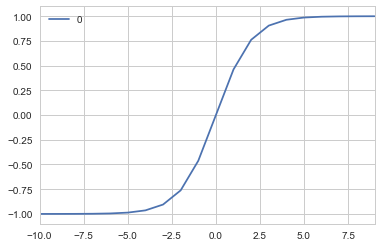

In [40]:
df = pd.DataFrame(F.sigmoid(np.arange(-10,10).astype(np.float32)).data * 2.0 - 1.0,
                  index=np.arange(-10,10))
df.plot()

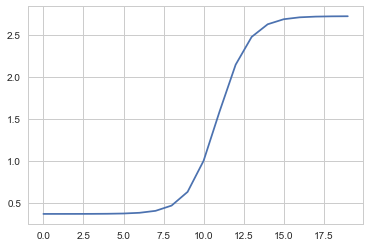

In [41]:
plt.plot(np.exp(F.sigmoid(np.arange(-10,10).astype(np.float32)).data * 2.0 - 1.0))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x208672f10>]], dtype=object)

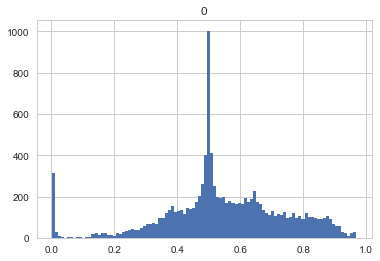

In [42]:
pd.DataFrame(px.data.ravel()).hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x20adf9450>]], dtype=object)

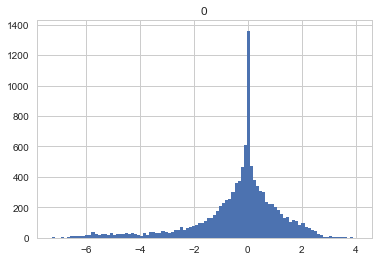

In [43]:
pd.DataFrame(pw.data.ravel()).hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x218204f50>]], dtype=object)

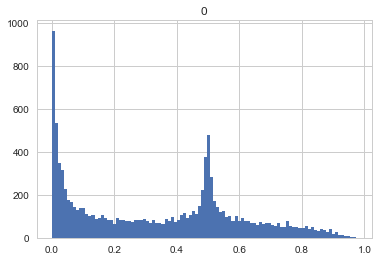

In [44]:
pd.DataFrame(pconf.data.ravel()).hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2087ebf10>]], dtype=object)

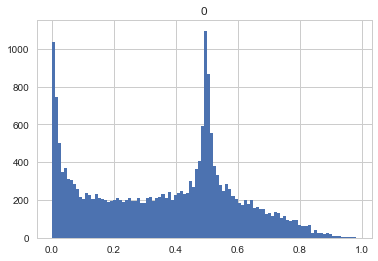

In [45]:
pd.DataFrame(pprob.data.ravel()).hist(bins=100)

## 推論を実行

In [21]:
h = model.predict(xs)

h.shape

(10, 5, 31, 7, 7)

In [27]:
for batch in six.moves.range(0, batch_size):
    tensors = h[batch]
    break

In [29]:
tensor = tensors[0]
tensor.shape

(31, 7, 7)

In [37]:
px, py, pw, ph, pconf, pprob = np.array_split(tensor, indices_or_sections=(1,2,3,4,5), axis=0)
px.shape, py.shape, pw.shape, ph.shape, pconf.shape, pprob.shape

((1, 7, 7), (1, 7, 7), (1, 7, 7), (1, 7, 7), (1, 7, 7), (26, 7, 7))

In [91]:
bboxes = inference_to_bounding_boxes(tensors)
bboxes[0]

(31, 7, 7)
(31, 7, 7)
(31, 7, 7)
(31, 7, 7)
(31, 7, 7)


[{u'bounding_box': <Box x:0.0 y:0.0 w:5.36378335208 h:5.34484065324 c:24 o:0.0116229793057>,
  u'grid_cell': <Point x:0.0 y:0.0>},
 {u'bounding_box': <Box x:0.0 y:0.0 w:5.81349337101 h:5.11981229484 c:1 o:0.0137211233377>,
  u'grid_cell': <Point x:1.0 y:0.0>},
 {u'bounding_box': <Box x:0.0 y:0.0 w:5.55217248201 h:5.13758713007 c:9 o:0.0125717334449>,
  u'grid_cell': <Point x:2.0 y:0.0>},
 {u'bounding_box': <Box x:0.695677131414 y:0.0 w:5.5168697238 h:5.09562050179 c:9 o:0.0115273986012>,
  u'grid_cell': <Point x:3.0 y:0.0>},
 {u'bounding_box': <Box x:1.75675602257 y:0.0 w:5.24324397743 h:5.04924795032 c:9 o:0.0126066785306>,
  u'grid_cell': <Point x:4.0 y:0.0>},
 {u'bounding_box': <Box x:2.80961772799 y:0.0 w:4.19038227201 h:5.12996822968 c:24 o:0.0052419132553>,
  u'grid_cell': <Point x:5.0 y:0.0>},
 {u'bounding_box': <Box x:3.86895987764 y:0.0 w:3.13104012236 h:5.14749535918 c:24 o:0.00539302686229>,
  u'grid_cell': <Point x:6.0 y:0.0>},
 {u'bounding_box': <Box x:0.0 y:0.0 w:5.344642

In [54]:
candidates = select_candidates(bboxes, 0.1)
candidates

[<Box x:1.97942268923 y:1.92749410942 w:1.23471081108 h:5.07250589058 c:9 o:0.718052506447>,
 <Box x:1.98739157133 y:2.56703711562 w:1.16019217148 h:4.43296288438 c:9 o:0.890877962112>,
 <Box x:1.97733604386 y:3.64657869413 w:1.1650912866 h:3.35342130587 c:9 o:0.237546771765>]

In [57]:
winners = nms(candidates, 0.5)
len(winners)

1

In [140]:
model_file = os.path.join('..', 'cmd', 'yolo', 'detector', 'snapshot_2017-04-16_193757', 'detector_final.model')
predictor = YoloPredictor(model_file=model_file)

load model: ../cmd/yolo/detector/snapshot_2017-04-16_193757/detector_final.model


In [74]:
image_paths = np.asarray([item['color_image_path'] for item in dataset])

In [141]:
bounding_boxes = predictor.predict(image_paths[0:3])

In [142]:
[select_candidates(bboxes_of_image, 0.3) for bboxes_of_image in bounding_boxes]

[[<Box x:180.97579469 y:0.0 w:112.887811865 h:409.356594086 c:9 o:0.718052566051>,
  <Box x:181.704354593 y:0.0 w:106.074726309 h:465.273270607 c:9 o:0.890877962112>],
 [<Box x:108.891244871 y:194.22479919 w:245.105192491 h:215.178624221 c:24 o:0.638067901134>,
  <Box x:179.705577918 y:210.60268202 w:265.145979609 h:207.473856977 c:24 o:0.643514633179>,
  <Box x:246.268816335 y:136.86764104 w:121.122667449 h:343.13235896 c:24 o:0.499296188354>],
 [<Box x:90.8729410172 y:296.432838397 w:507.758207321 h:152.22268658 c:12 o:0.6451638937>,
  <Box x:168.063427636 y:299.880572728 w:452.508311442 h:142.973205021 c:12 o:0.760770201683>,
  <Box x:187.45475173 y:295.536933392 w:273.991133486 h:163.740327486 c:12 o:0.320963650942>,
  <Box x:259.160286188 y:300.006557746 w:297.86987475 h:146.310212527 c:12 o:0.345788061619>]]

## 教師データを作成

In [46]:
tx = np.tile(0.5, px.shape) # 基本はグリッド中心
ty = np.tile(0.5, py.shape)
tw = np.zeros(ph.shape) # e^t,e^h = 1となるよう基本は0
th = np.zeros(ph.shape)
tconf = np.zeros(pconf.shape) # 基本は0
tprob = pprob.data.copy() # 真のグリッド以外は誤差が発生ないよう推定値をコピー

In [47]:
def all_pred_boxes(px, py, pw, ph):
    x_offsets = np.broadcast_to(np.arange(N_GRID).astype(np.float32), px.shape)
    y_offsets = np.broadcast_to(np.arange(N_GRID).astype(np.float32), py.shape)
    w_anchors = np.broadcast_to(np.reshape(np.array(ANCHOR_BOXES).astype(np.float32)[:,0], (N_BOXES,1,1,1)), pw.shape)
    h_anchors = np.broadcast_to(np.reshape(np.array(ANCHOR_BOXES).astype(np.float32)[:,0], (N_BOXES,1,1,1)), ph.shape)
    return Box(x=x_offsets + F.sigmoid(px).data, y=y_offsets + F.sigmoid(py).data,
               width=np.exp(pw) * w_anchors, height=np.exp(ph) * h_anchors)

In [48]:
best_ious = []
for batch in range(0, batch_size):
    ious = []
    pboxes = all_pred_boxes(px.data[batch], py.data[batch], pw.data[batch], ph.data[batch])
    for truth_box in ground_truths[batch]:
        tboxes = Box(
            x=np.broadcast_to(np.array(truth_box.left).astype(np.float32), pboxes.left.shape),
            y=np.broadcast_to(np.array(truth_box.top).astype(np.float32), pboxes.top.shape),
            width=np.broadcast_to(np.array(truth_box.width).astype(np.float32), pboxes.width.shape),
            height=np.broadcast_to(np.array(truth_box.height).astype(np.float32), pboxes.height.shape)
        )
        ious.append(Box.iou(pboxes, tboxes))

    ious = np.asarray(ious)
    best_ious.append(np.max(ious, axis=0))

best_ious = np.asarray(best_ious).reshape(batch_size, N_BOXES, 1, N_GRID, N_GRID)

ValueError: input operand has more dimensions than allowed by the axis remapping

In [49]:
best_ious.shape

AttributeError: 'list' object has no attribute 'shape'

In [50]:
pconf[best_ious > 0.1]

/Users/uents/.anyenv/envs/pyenv/versions/anaconda2-4.3.0/lib/python2.7/site-packages/chainer/functions/array/get_item.py:42: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  return utils.force_array(ary[tuple(self.slices)]),


In [51]:
pconf.data.copy()[best_ious > 0.1]

/Users/uents/.anyenv/envs/pyenv/versions/anaconda2-4.3.0/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  if __name__ == '__main__':


array([[[ 0.49989817,  0.47988531,  0.49052176, ...,  0.53186619,
          0.45669949,  0.50410372]],

       [[ 0.52191216,  0.48412836,  0.48864543, ...,  0.54230201,
          0.53637093,  0.49477589]],

       [[ 0.51013553,  0.50069791,  0.50773203, ...,  0.5119676 ,
          0.48797908,  0.48580599]],

       ..., 
       [[ 0.4857654 ,  0.27156287,  0.03514016, ...,  0.03644538,
          0.29046455,  0.50739259]],

       [[ 0.53162986,  0.38114056,  0.08133149, ...,  0.22252616,
          0.79771686,  0.75063086]],

       [[ 0.64361501,  0.34199813,  0.04730505, ...,  0.15084293,
          0.53113973,  0.60997415]]], dtype=float32)

## 推論の結果を評価

In [52]:
h.shape

(10, 155, 7, 7)

In [53]:
tensor = h[0]
tensor.shape

(155, 7, 7)

In [54]:
tensor[0].shape

(7, 7)

In [55]:
px, py, pw, ph, pconf, pprob = np.array_split(tensor[0], indices_or_sections=(1,2,3,4,5), axis=0)
pconf = F.sigmoid(pconf).data

px.shape, py.shape, pw.shape, ph.shape, pconf.shape, pprob.shape

InvalidType: 
Invalid operation is performed in: GetItem (Forward)

Expect: in_types[0].ndim >= 1
Actual: 0 < 1

In [56]:
# グリッド毎のクラス確率を算出 (N_BOXES, N_CLASSES, N_GRID, N_GRID)
class_prob_map = pprob * pconf

# 最大クラス確率となるクラスラベルを抽出 (N_BOXES, N_GRID, N_GRID)
class_label_map = class_prob_map.argmax(axis=0)

# 最大クラス確率が閾値以上のグリッドを検出候補として抽出 (N_BOXES, N_GRID, N_GRID)
candidate_map = class_prob_map.max(axis=0) > CLASS_PROBABILITY_THRESH

# 検出候補のグリッド位置を抽出 (N_BOXES, )
grid_cells = [Point(x=float(point[1]), y=float(point[0])) for point in np.argwhere(candidate_map)]

InvalidType: 
Invalid operation is performed in: _ * _ (Forward)

Expect: in_types[0].shape == in_types[1].shape
Actual: (10, 155, 2, 7) != (10, 155, 1, 7)

In [ ]:
px[0][candidate_map][0]

In [ ]:
candidates = []
for i in six.moves.range(0, candidate_map.sum()):
    w = np.exp(pw[candidate_map][i]) * anchor_box[0]
    h = np.epx(ph[candidate_map][i]) * anchor_box[1]
    x = max(px[candidate_map][i] + grid_cell.x - w/2, 0.)
    y = max(py[candidate_map][i] + grid_cell.y - h/2, 0.)
    w = min(w, N_GRID - x)
    h = min(h, N_GRID - y)
    grid_box = Box(x=x, y=y, width=w, height=h,
                           confidence=pconf[candidate_map][i],
                           clazz=class_label_map[candidate_map][i],
                           objectness=class_prob_map.max(axis=0)[candidate_map][i])
    candidates.append(grid_to_yolo_coord(grid_box, grid_cells[i]))

In [ ]:
pconf[0][candidate_map]

In [ ]:
plt.plot(F.tanh(np.arange(-100,100,2).astype(np.float32) / 100.).data)

In [ ]:
np.exp(0)

In [ ]:
F.tanh(np.arange(-100,100,2)).data

In [ ]:
pd.DataFrame(np.exp(np.arange(-1,1,0.1)), index=np.arange(-1,1,0.1)).plot()

In [ ]:
np.random.randint(0, 255, size=(1,3,224,224)) / 255.

In [ ]:
ANCHOR_BOXES = np.array([[5.375, 5.03125], [5.40625, 2.6875], [2.96875, 2.53125], [1.59375, 1.78125], [1.2375, 5.25]])
int(len(ANCHOR_BOXES))

In [ ]:
np.sort(np.asarray([0.09165094, 0.15258172, 0.69590072, 0.17525685, 0.78319937, 0.64341082,
      0.59390963, 0.61937724, 0.61221406, 0.19246834, 0.63833827, 0.,
      0.07429834, 0.68174421, 0.301886, 0.36671587, 0.70641377, 0.17396223,
      0.19986209, 0.57469907]))[::-1]

In [ ]:
truth_box = ts[0][0]
truth_box

In [ ]:
anchor_ious = np.asarray([Box.iou(Box(0., 0., anchor_box[0], anchor_box[1]),
                            Box(0., 0., truth_box.width, truth_box.height))
                    for anchor_box in ANCHOR_BOXES])

In [ ]:
anchor_ious

In [ ]:
np.argmax(anchor_ious)